# Spooky authors identification

[https://www.kaggle.com/c/spooky-author-identification]

## Description

> As I scurried across the candlelit chamber, manuscripts in hand, I thought I'd made it. Nothing would be able to hurt me anymore. Little did I know there was one last fright lurking around the corner.

> DING! My phone pinged me with a disturbing notification. It was Will, the scariest of Kaggle moderators, sharing news of another data leak.

> "ph’nglui mglw’nafh Cthulhu R’lyeh wgah’nagl fhtagn!" I cried as I clumsily dropped my crate of unbound, spooky  books. Pages scattered across the chamber floor. How will I ever figure out how to put them back together according to the authors who wrote them? Or are they lost, forevermore? Wait, I thought... I know, machine learning!

---

In this year's Halloween playground competition, you're challenged to predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft. We're encouraging you (with cash prizes!) to share your insights in the competition's discussion forum and code in Kernels. We've designated prizes to reward authors of kernels and discussion threads that are particularly valuable to the community. Click the "Prizes" tab on this overview page to learn more.


## Inspiration

* Какви типове машинно самообучение вървят най-добре върху това множество?
* Кои признаци съдържат в себе си най-много стилът на съответния автор?

Задачата, която се решава е класификация на текст в три класа, които не се пресичат - кой е авторът, написал дадения текст?


## Съдържание на файла


| Атрибут           | Стойности               
| ----------------- | -----------------------: 
| id                | Идентифактор на текста
| text              | Текстово съдържание - откъс
| author            | Автор на откъса

## Четене на данните

In [2]:
import re
import math
import random
random.seed(1)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


# Reading all from the csv
spooky = pd.read_csv('data/train.csv')

# Show the top 5 rows
spooky.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
# Show the shape of dataset
spooky.shape

(19579, 3)

In [4]:
# Check the counts for the classes
spooky.groupby('author').size()

author
EAP    7900
HPL    5635
MWS    6044
dtype: int64

In [5]:
# Check for null values
spooky.isnull().sum()

id        0
text      0
author    0
dtype: int64

Преди да започнем работа с текстовете, искаме да се убедеим, че няма такива, които съдържат празни места преди и след изреченията, т.е. не са от вида "  text  ". 

За целта прилагаме следната процедура:

In [6]:
spooky["text"] = spooky["text"].apply(lambda x: x.strip())

## Статистически анализ

Преди да преминем към класификацията на авторите, бихме искали да разгледаме няколко от статистическите качества на текста.

### Разпределение на дължините

Ще покажем как изглежда разпределението на дължините на текст, написан от даден автор. 

За целта генерираме нова колона, която съответства на дължината.

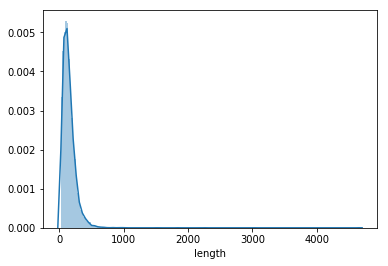

In [7]:
spooky["length"] = spooky["text"].apply(lambda x: x.__len__())

sns.distplot(spooky["length"], bins=200)
plt.show()

Оказва се, че данните са много разпределени в ляво (по-малки от 1000) и има много малко в дясно (по-големи от 1000). 

Затова ще искаме да видим как изглеждат дължините в логаритмичен мащаб.

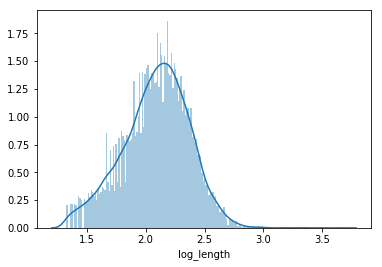

In [8]:
spooky["log_length"] = spooky["text"].apply(lambda x: math.log(x.__len__(), 10))

sns.distplot(spooky["log_length"], bins=200)
plt.show()

След логаритмичното преобразуване, новата графика показва сравнително по-ясно как изглежда разпределението на дължините, а именно, че късите текстове (под 100 думи) са голяма част от тренировъчното множество, а тези над 1000 са изключително редки. Повечето текстове са между 100 и 1000 думи.

Нека видим как изглежда разпределението спрямо авторите.

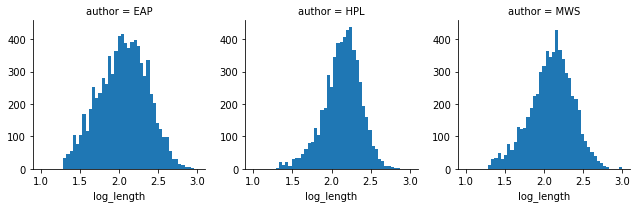

In [9]:
g = sns.FacetGrid(spooky, col="author", margin_titles=True)
bins = np.linspace(1.0, 3.0)
g.map(plt.hist, "log_length", bins=bins, lw=0)
plt.show()

Виждаме, че разпределенията изглеждат доста сходно, досъщ като нормални разпределения (Гаусови криви), като и трите са центрирани около 2. 

Обаче това което ги различава би трябвало да е стандартното им отклонение. 

За да тестваме тази хипотеза, ще използваме методът на максимално правдоподобие, като детайли можем да видим тук:
[https://en.wikipedia.org/wiki/Maximum_likelihood_estimation#Continuous_distribution,_continuous_parameter_space]

В конкректния случай се опитваме да апроксимираме какво ще е най-доброто нормално разпределение N(mu, sigma), което най-добре ще пасне на съответната извадка:

![normal](http://equplus.net/png/0258.png "Normal distribution")

In [10]:
from scipy.stats import norm
print(norm.fit(spooky[spooky["author"]=="EAP"]["log_length"]))
print(norm.fit(spooky[spooky["author"]=="HPL"]["log_length"]))
print(norm.fit(spooky[spooky["author"]=="MWS"]["log_length"]))

(2.0480557531354577, 0.30725175361736379)
(2.1327805068263186, 0.23747928855010164)
(2.0930252275965873, 0.27842118398177412)


От статистическия анализ получаваме, че:
 * EAP и MWS са с почти еднаква средна стойност (2.07)
 * EAP има повече разнородни стойности отколкото MWS, т.е. има по-голямо стандартно отклонение
 * HPL е изместен в дясно (2.13), и има най-малко стандартно отклонение (0.24).
 
За съжаление, тъй като тези разпределения са много сходни (даже се припокриват почти изцяло), не можем да им разчитаме за класификация. Обаче, ако едното беше изместено много спрямо другото, това ни дава наготово вече трениран наивен Бейсов класификатор, като работата с него е:
 * Определяме разпределенията по-горе със същия анализ
 * Намираме къде те се пресичат. С малко интегрални сметки се доказва, че пресечната точка на двойка разпределения съответства на разделителната равнина между двата класа.
 * Получаваме нова точка и гледаме къде се пада тя спрямо тази пресечната точка. В зависимост от коя страна се намира, определяме клас на разглеждания пример.

### Честотно разпределение на символите

Като следваща стъпка от статистическия анализ, можем да направим оценка на това кой автор колко пъти е ползвал съответна буква.

Съответно, бихме искали да нормализираме тези бройки, като ги взимаме като процент от общия брой знаци.

In [11]:
buckets = dict()
buckets["EAP"] = dict()
buckets["HPL"] = dict()
buckets["MWS"] = dict()

counts = dict()
counts["EAP"] = 0
counts["HPL"] = 0
counts["MWS"] = 0

# Calculate counts and buckets dicts per author

for row in spooky.values:
    for c in row[1]:
        if c not in buckets[row[2]]:
            buckets[row[2]][c] = 0
        buckets[row[2]][c] += 1
        counts[row[2]] += 1

# Normalize the frequnecy in percents

for a in buckets:
    for b in buckets[a]:
        buckets[a][b] /= counts[a]

# Here we need the frequency dict as tuple,
# so that we can sort it.

char_dist = dict()
char_dist["EAP"] = list()
char_dist["HPL"] = list()
char_dist["MWS"] = list()

for author in buckets:
    for char in buckets[author]:
        char_dist[author].append((char, buckets[author][char]))
    char_dist[author] = sorted(char_dist[author], key=lambda x: x[1], reverse=True)

# Build pandas DataFrame

eap_chars = pd.DataFrame(char_dist["EAP"],  columns=["char", "frequncy"])
hpl_chars = pd.DataFrame(char_dist["HPL"],  columns=["char", "frequncy"])
mws_chars = pd.DataFrame(char_dist["MWS"],  columns=["char", "frequncy"])

# gc

del char_dist
del buckets
del counts

# Store to out as csv

eap_chars.to_csv("out/eap_chars.csv")
hpl_chars.to_csv("out/hpl_chars.csv")
mws_chars.to_csv("out/mws_chars.csv")

eap_chars.head(30)

,char,frequncy
0,,0.171856
1,e,0.102249
2,t,0.073360
3,a,0.060988
4,o,0.059760
5,n,0.055747
6,i,0.054248
7,s,0.047919
8,h,0.045907
9,r,0.045587


Първото, което се вижда е, че малките букви следват една и съща последователност, която се изразява по един и същи начин. Наблюдават се и съвсем малки флуктуации, но те са незначителни.

При главните букви също се наблюдава сравнително еднакви подреждания, макар и те да не се различават 

От пунктуационните знаци можем да видим следните тенденции:
 * При HPL "," е по-рядък. Това може би означава, че той използва по-дълги и прости изречения.
 * При MWS ";" e по-рядък.
 * Отношението за знака " е MWS:EAP:HPL = 2.5 : 4 : 1. Това е вероятността авторът да е ползвал непряка реч. Този знак не е употребяван изрично само за това. Има изречения, които само започват или само завършват с него. За това неговите стойности трябва да се закръглят mod 2.
 * Отношението за знака ' е MWS:EAP:HPL = 1 : 2.3 : 4. Това е употребата на определени глаголни времена и собственост в английския. Въпреки, че се използва като знак за непряка реч, това не го компрементира, тъй като особената му употреба е в средата на изречението.
 * Отношението за знака "?" е MWS:EAP:HPL = 2 : 2 : 1. Това е употребата на въпросителни изречения. Явно HPL е питал повече въпроси.
 * Отношението за знака ":" е MWS:EAP:HPL = 7 : 3 : 1. Това е употребата на изброявяния и непряка рея. Явно при правил повече изборявяния.
 * Няма други препинателни знаци. Странно няма удивителни :)

Как можем да използваме тази статистика?

Като сметнем разпределението на тестовия пример, бихме могли да го сравним към кой той е най-близо. Освен това допълнително можем да отделим пунктуацията, и да използваме всеки знак като различен feature.

---

Бележки към този тип анализ

---

Без да задълбаваме в подробности, ще кажем че това е метод, с който се е чупил криптографията допреди около 100 години, която е разчитала на завъртането на буквите в азбуката:
[https://en.wikipedia.org/wiki/Vigen%C3%A8re_cipher#Cryptanalysis]

Дори въпросният честотен анализ би свършил работа, ако е криптирано с блок шифър, който е приложен в ECB режим, т.е. всяка блок се кодира по един и същ начин. Това запазва структурата, съответно и честотното разпределение на символите:
[https://en.wikipedia.org/wiki/Block_cipher_mode_of_operation#Electronic_Codebook_.28ECB.29]

## Подготовка на думите

За да улесним работата с токените, ги разглеждаме само в ниския регистър, т.е. само като малки букви.

In [12]:
spooky["content"] = spooky["text"].apply(lambda x: x.lower())

spooky.describe()

,length,log_length
count,19579.000000,19579.000000
mean,149.057408,2.086322
std,106.800189,0.281926
min,21.000000,1.322219
25%,81.000000,1.908485
50%,128.000000,2.107210
75%,191.000000,2.281033
max,4663.000000,3.668665


### Пунктуационен подпис

За всеки откъс можем да съставим пунктуационен подпис, като реално
преборим колко пъти се среща съответния знак и запишем тази двойката:
    * знак
    * # срещания

In [13]:
def punctuation_signature(text):
    signature = dict()
    signature["."] = 0
    signature["\""] = 0
    signature["?"] = 0
    signature[","] = 0
    signature[";"] = 0
    signature["'"] = 0
    signature[":"] = 0
    
    for c in re.findall("[\.\"?,;':]", text):
        signature[c] += 1
    
    return signature

# This stores the punctuation signatures

punctuation_storage = dict()

for row in spooky.values:
    punctuation_storage[row[0]] = punctuation_signature(row[1])


### Езиково зависима подготовка

Тъй като това е английски език, ще искаме да превръщаме форми като "it's" в "it is", за да имаме по-пълно съответствие. За целта искаме да видим всяка дума, която съдържа '

In [14]:
hits = dict()

# Read all tokens with '

for row in spooky.values:
    for item in row[1].split(" "):
        if "'" in item:
            if item not in hits:
                hits[item] = 0
            hits[item]+=1

# Sort tokens by count

items = list()
for hit in hits:
    items.append((hit, hits[hit]))

items = sorted(items, key=lambda x: x[1], reverse=True)

for item in items:
    print(item)

del hits
del items

("an'", 187)
("o'", 98)
("don't", 57)
("man's", 46)
("father's", 36)
("o'clock", 32)
("earth's", 30)
("mother's", 27)
("'em", 27)
("can't", 27)
("didn't", 24)
("Raymond's", 22)
("it's", 21)
("ain't", 19)
("he's", 18)
("world's", 17)
("I'm", 17)
("West's", 16)
("o'clock,", 16)
("I've", 16)
("Adrian's", 15)
("couldn't", 15)
("that's", 15)
("L'Espanaye", 14)
("'The", 14)
("uncle's", 14)
("It's", 14)
("death's", 14)
("Whateley's", 13)
("Perdita's", 13)
("wouldn't", 13)
("Gilman's", 12)
("wa'n't", 11)
("dun't", 11)
("I'll", 11)
("L'Etoile", 11)
("wasn't", 11)
("you're", 10)
("God's", 10)
("won't", 10)
("there's", 10)
("Jupiter's", 10)
("I'd", 10)
("other's", 9)
("'Oppodeldoc,'", 9)
("one's", 9)
("Don't", 9)
("sister's", 9)
("nothin'", 8)
("potter's", 8)
("daughter's", 8)
("men's", 8)
("'I", 8)
("they'd", 8)
("'tis", 8)
("goin'", 8)
("they's", 8)
("'the", 8)
("moon's", 7)
("An'", 7)
("'that", 7)
("day's", 7)
("night's", 7)
("'Rowdy", 7)
("brother's", 7)
("girl's", 7)
("Cap'n", 7)
("grandfath

След като видяхме тези срещания, бихме могли да получим и подобна таблица с правила, на тази която е приложена долу.

In [15]:
def english_rules(text):
    rules = [
        (" '", " "),("in' ", "ing "),
        (" an' ", " and "), ("in' ", "ing "), (" o' ", " of "), 
        (" don't ", " do not "), (" 'em ", " them "), (" can't ", " can not "),
        (" didn't ", " did not "), (" it's ", " it is "),(" ain't ", " are not "), (" he's ", " he is "),
        (" i'm ", " i am "), (" I've ", " I have "),(" couldn't ", " could not "), (" that's ", " that is "),
        (" wouldn't ", " I am "), (" wa'n't ", " was not "),(" i'll ", " i will "), (" wasn't ", " was not "),
        (" you're ", " you are "), (" won't ", " will not "),(" there's ", " there is "), (" i'd ", " i would "),
        (" don't ", " do not "), (" they'd ", " they would "),(" cap'n ", " captain "), (" isn't ", " is not "),
        (" they're ", " they are "), (" he'd ", " he would "),(" doesn't ", " does not "), (" they've ", " they have "),
        (" aren't ", " are not "), (" dxn't ", " do not "),(" hadn't ", " had not "), (" he'll ", " he will "),
        (" mustn't ", " must not "), (" you'll ", " you will "),(" dat's ", " that is "), (" wun't ", " will not "),
        (" shouldn't ", " should not "), (" n't ", " not "),(" hain't ", " have not "), (" ne'er ", " never "),
        (" they'll ", " they will "), (" ye'll ", " you will "),(" we're ", " we are "), (" haven't ", " have not "),
        (" we've ", " we have "), (" weren't ", " were not "),(" you've ", " you have "), (" you'd ", " you would "),
        (" hasn't ", " has not "), (" needn't ", " need not "),(" here's ", " here is "), (" thing's ", " thing is "),
        (" she's ", " she is "), (" she'd ", " she would "), (" cannot ", " can not "),
        ("v'd ", "ved "),
        ("y'd ", "yed "),
    ]
    
    for rule in rules:
        text = text.replace(rule[0], rule[1])
    
    return text

spooky["content"] = spooky["content"].apply(lambda x: english_rules(x))


### Токенизация

Целта на подготовката е да раздели текста на токени - това са парчета от него, които след това можем да обработим по различен начин.



In [22]:
def tokenize(text):
    return re.findall("[a-z]+", text)

spooky["tokens"] = spooky["text"].apply(lambda x: tokenize(x))

### Стематизация

Стематизацията представлява автоматизирано трансформиране от форма на думата към нейната основна форма, базирайки се на някакви правила. За целта английския е доста подходящ и има доста добър алгоритъм за това - Snowball. 

In [17]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
print(stemmer.stem("running"))

run


In [18]:
def apply_stemming(tokens):
    for k, t in enumerate(tokens):
        tokens[k] = stemmer.stem(t)
    return tokens
    
spooky["tokens"] = spooky["tokens"].apply(lambda x: apply_stemming(x))

## Анализ на думите

### Дължини на откъсите

Искаме да представим графично по колко думи се срещат в изречение.  

In [19]:
def fragment_length(tokens):
    return tokens.__len__()    
spooky["fragment_length"] = spooky["tokens"].apply(lambda x: fragment_length(x))

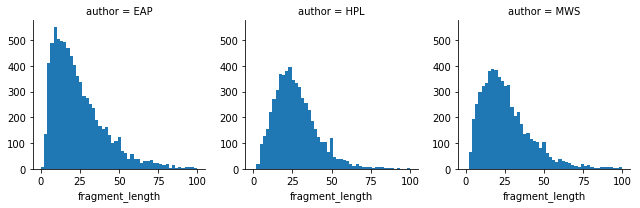

In [23]:
g = sns.FacetGrid(spooky, col="author", margin_titles=True)
bins = np.linspace(0, 100.0)
g.map(plt.hist, "fragment_length", bins=bins, lw=0)
plt.show()

In [21]:
print(norm.fit(spooky[spooky["author"]=="EAP"]["fragment_length"]))
print(norm.fit(spooky[spooky["author"]=="HPL"]["fragment_length"]))
print(norm.fit(spooky[spooky["author"]=="MWS"]["fragment_length"]))

(24.955949367088607, 18.409534783207999)
(27.417923691215616, 14.098026630440703)
(26.724685638649902, 22.608148341397992)


### Употреба на думите

In [24]:
spooky["tokens"]

0        [his, process, however, afforded, me, no, mean...
1        [t, never, once, occurred, to, me, that, the, ...
2        [n, his, left, hand, was, a, gold, snuff, box,...
3        [ow, lovely, is, spring, s, we, looked, from, ...
4        [inding, nothing, else, not, even, gold, the, ...
5        [youth, passed, in, solitude, my, best, years,...
6        [he, astronomer, perhaps, at, this, point, too...
7        [he, surcingle, hung, in, ribands, from, my, b...
8        [knew, that, you, could, not, say, to, yoursel...
9        [confess, that, neither, the, structure, of, l...
10       [e, shall, find, that, can, feel, my, injuries...
11       [ere, we, barricaded, ourselves, and, for, the...
12       [erbert, est, needed, fresh, bodies, because, ...
13       [he, farm, like, grounds, extended, back, very...
14       [ut, a, glance, will, show, the, fallacy, of, ...
15       [e, had, escaped, me, and, must, commence, a, ...
16       [o, these, speeches, they, gave, of, course, t.